|평가문항|상세기준|
|---|---|
|1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.|
|2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.|
|3. Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

In [6]:
# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)


2.6.0
1.21.4


In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

In [224]:
from tensorflow import keras
# function for building VGG Block

def conv_block(input_layer, 
                k_sizes=[3, 3],
                strides=[1,1],
                channels=[64, 64],
               stage=None,
               block_num=None,
              ):
    # 입력 레이어
    x = input_layer
    num_layers = len(strides)
    for i, spec in enumerate(zip(k_sizes, strides, channels)):
        k_size, stride, channel = spec

        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(k_size,k_size),
            strides=stride,
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'stage{stage}_{block_num}_conv{i}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x) if i < num_layers-1 else x
        
    return x

def first_block(
        input_layer,
):
    # 입력 레이어
    x = input_layer
    x = keras.layers.Conv2D(
            kernel_size=(7,7),
            filters=64,
            strides=2,
            activation=None,
            kernel_initializer='he_normal',
            padding='same',
            name=f'conv2d_15'
        )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'stage1_0_maxpooling'
    )(x)
    
    return x
    
def build_block(
        input_layer,
        num_cnn=3, 
        first_layer_stride=1,
        channel=64,
        block_num=1,
        is_50=False,
        stage=0,
        residual=True
    ):
    # 입력 레이어
    x = input_layer
    channel_list = [channel,channel, 4*channel] if is_50 else [channel,channel]
    filters_out = channel_list[-1]
    
    # CNN 레이어
    for cnn_num in range(num_cnn):
#         print(f'block:{cnn_num}')
        x_shortcut = x
        strides_list = [first_layer_stride,1] if cnn_num == 0 else [1,1]
        strides_list += [1] if is_50 else []
        x = conv_block(
            x,
            k_sizes=[1,3,1] if is_50 else [3,3],
            strides=strides_list,
            channels=channel_list,
            stage=stage,
            block_num = cnn_num
        )
        if residual:    
            shortcut_channel = x_shortcut.shape.as_list()[-1]
            shortcut_size = x_shortcut.shape.as_list()[-2]
            x_size = x.shape.as_list()[-2]
            strides = tuple([shortcut_size//x_size] * 2)
            if shortcut_channel != filters_out:
                # matching dimensions of tensors thtough shortcut connection and conv layer
                # using cnv (k=1x1, stride=2 if downsampling is needed else 1)
                x_shortcut = keras.layers.Conv2D(
                    filters_out, kernel_size=(1, 1), strides=strides, 
                    name=f'stage{stage}_{cnn_num}_short',
                    padding="same")(x_shortcut)
            # add two tensors
            x = keras.layers.Add(name=f'stage{stage}_{cnn_num}_add')([x, x_shortcut])
        # passing through after adding tensors
        x = keras.layers.ReLU()(x)
    return x

In [225]:
from tensorflow import keras

vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = first_block(vgg_input_layer)

vgg_block_output = build_block(
    vgg_block_output,
    num_cnn=3,
    stage=1 
)    

# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   9472        input_65[0][0]                   
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 16, 16, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
re_lu_32 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_32[0][0]     
___________________________________________________________________________________________

In [226]:
from tensorflow import keras

# VGG 모델 자체를 생성하는 함수입니다.
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=2,
              is_50=False,
              is_resnet=True,
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    output = first_block(input_layer)
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
#         print(f'stage:{i}')
        output = build_block(
            output,
            num_cnn=3,
            channel = channel,
            first_layer_stride=2 if i > 0 else 1,
            stage=i,
            residual=is_resnet,
            is_50=is_50,
        )
    
    output = keras.layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(1000, activation='relu', name='fc1000')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

[루브릭1] 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.

In [227]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   9472        input_66[0][0]                   
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 16, 16, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
re_lu_39 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_39[0][0]     
___________________________________________________________________________________________

In [228]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "model_38"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 16, 64)   9472        input_67[0][0]                   
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 16, 16, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
re_lu_64 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_64[0][0]     
___________________________________________________________________________________________

In [194]:
BATCH_SIZE = 256
EPOCH = 15
INPUT_SHAPE = (32, 32, 3)

In [195]:
import urllib3
urllib3.disable_warnings()
#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

In [229]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    ## normalize
    
    ## resize
    image = tf.image.resize(
        image,
        size=(32, 32),
        preserve_aspect_ratio=False,
        antialias=False,
        name=None
    )
    return image / 255, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [230]:
import tensorflow_datasets as tfds

setattr(
    tfds.image_classification.cats_vs_dogs, 
    '_URL',
    "https://download.microsoft.com/download/3/E/1/"
    "3E1C3F21-ECDB-4869-8368-6DEBA77B919F/"
    "kagglecatsanddogs_5340.zip")

(ds_train, ds_val, ds_test), ds_info  = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]', 'train[90%:]'],
    # ref: https://www.tensorflow.org/datasets/splits?hl=ko
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [231]:
print(f'the size of train set: {len(ds_train)}')
print(f'the size of train set: {len(ds_val)}')
print(f'the size of train set: {len(ds_test)}')

the size of train set: 18610
the size of train set: 2326
the size of train set: 2326


In [232]:
print( 'the names of classes (num_tot): {cls_names}({num_class})'.format(
    num_class=ds_info.features["label"].num_classes,
    cls_names=ds_info.features["label"].names,
))

the names of classes (num_tot): ['cat', 'dog'](2)


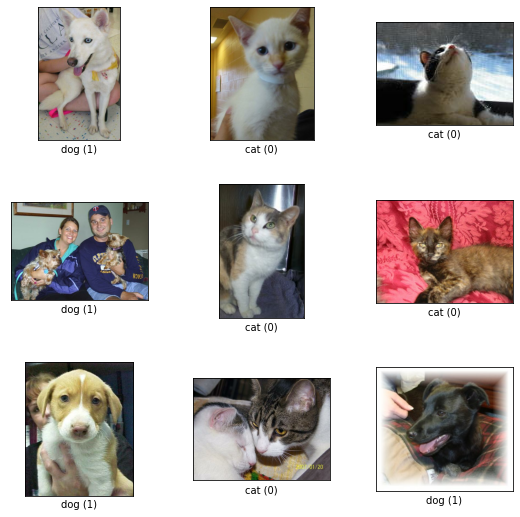

In [212]:
fig = tfds.show_examples(ds_train, ds_info)

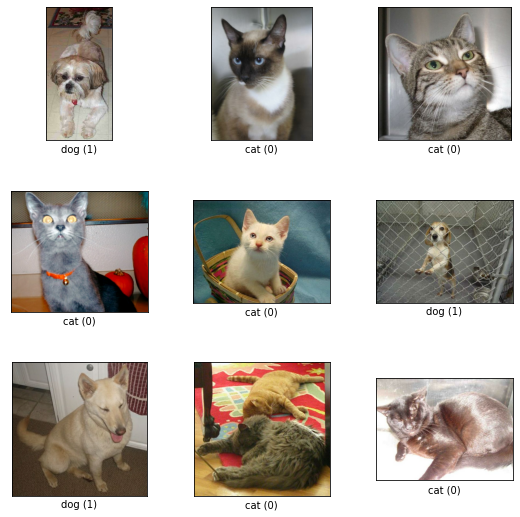

In [213]:
fig = tfds.show_examples(ds_test, ds_info)

In [233]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_val = apply_normalize_on_dataset(ds_val, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [234]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples*0.8/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train'].num_examples*0.1/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd

13/72 [====>.........................] - ETA: 6s - loss: 0.8380 - accuracy: 0.5195

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


14/72 [====>.........................] - ETA: 6s - loss: 0.8332 - accuracy: 0.5215

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


16/72 [=====>........................] - ETA: 6s - loss: 0.8253 - accuracy: 0.5239

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 5s - loss: 0.7946 - accuracy: 0.5418

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


45/72 [=================>............] - ETA: 3s - loss: 0.7456 - accuracy: 0.5668

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.7413 - accuracy: 0.5686

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 1s - loss: 0.7137 - accuracy: 0.5913

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.6058

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 60s 447ms/step - loss: 0.6969 - accuracy: 0.6058 - val_loss: 0.7129 - val_accuracy: 0.5026
Epoch 2/15
12/72 [====>.........................] - ETA: 10s - loss: 0.5810 - accuracy: 0.6967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


16/72 [=====>........................] - ETA: 8s - loss: 0.5794 - accuracy: 0.7013

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 7s - loss: 0.5878 - accuracy: 0.6954

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


46/72 [==================>...........] - ETA: 3s - loss: 0.5403 - accuracy: 0.7358

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


50/72 [===================>..........] - ETA: 3s - loss: 0.5269 - accuracy: 0.7471

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


61/72 [========================>.....] - ETA: 1s - loss: 0.5108 - accuracy: 0.7601

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7751

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 32s 456ms/step - loss: 0.4921 - accuracy: 0.7751 - val_loss: 0.7215 - val_accuracy: 0.5087
Epoch 3/15
14/72 [====>.........................] - ETA: 5s - loss: 0.4432 - accuracy: 0.8066

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


17/72 [======>.......................] - ETA: 5s - loss: 0.4263 - accuracy: 0.8169

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


21/72 [=======>......................] - ETA: 5s - loss: 0.4167 - accuracy: 0.8250

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


47/72 [==================>...........] - ETA: 2s - loss: 0.4084 - accuracy: 0.8297

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


51/72 [====================>.........] - ETA: 2s - loss: 0.4166 - accuracy: 0.8250

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 1s - loss: 0.4027 - accuracy: 0.8323

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8402

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 32s 453ms/step - loss: 0.3907 - accuracy: 0.8402 - val_loss: 0.7599 - val_accuracy: 0.5213
Epoch 4/15
14/72 [====>.........................] - ETA: 4s - loss: 0.2913 - accuracy: 0.8984

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


18/72 [======>.......................] - ETA: 3s - loss: 0.2935 - accuracy: 0.8978

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


22/72 [========>.....................] - ETA: 4s - loss: 0.2908 - accuracy: 0.8977

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


48/72 [===================>..........] - ETA: 2s - loss: 0.2616 - accuracy: 0.9123

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


52/72 [====================>.........] - ETA: 2s - loss: 0.2600 - accuracy: 0.9137

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


63/72 [=========================>....] - ETA: 1s - loss: 0.2551 - accuracy: 0.9156

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.9180

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0

72/72 [==============================] - 33s 459ms/step - loss: 0.2484 - accuracy: 0.9180 - val_loss: 0.7650 - val_accuracy: 0.5614
Epoch 5/15
 3/72 [>.............................] - ETA: 6s - loss: 0.2696 - accuracy: 0.8932

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


10/72 [===>..........................] - ETA: 4s - loss: 0.2265 - accuracy: 0.9258

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.1523 - accuracy: 0.9594

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


53/72 [=====================>........] - ETA: 1s - loss: 0.1478 - accuracy: 0.9613

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


63/72 [=========================>....] - ETA: 0s - loss: 0.1496 - accuracy: 0.9594

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.1399 - accuracy: 0.9631

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 33s 469ms/step - loss: 0.1399 - accuracy: 0.9631 - val_loss: 0.8767 - val_accuracy: 0.5541
Epoch 6/15
34/72 [=============>................] - ETA: 2s - loss: 0.0679 - accuracy: 0.9863

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


43/72 [================>.............] - ETA: 2s - loss: 0.0629 - accuracy: 0.9885

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


64/72 [=========================>....] - ETA: 0s - loss: 0.0614 - accuracy: 0.9885

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9883

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 36s 500ms/step - loss: 0.0610 - accuracy: 0.9883 - val_loss: 1.0012 - val_accuracy: 0.5888
Epoch 7/15
53/72 [=====================>........] - ETA: 1s - loss: 0.0213 - accuracy: 0.9981

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


59/72 [=======================>......] - ETA: 0s - loss: 0.0207 - accuracy: 0.9983

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


66/72 [==========================>...] - ETA: 0s - loss: 0.0197 - accuracy: 0.9985

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0189 - accuracy: 0.9986

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd

72/72 [==============================] - 32s 445ms/step - loss: 0.0189 - accuracy: 0.9986 - val_loss: 1.2642 - val_accuracy: 0.5751
Epoch 8/15
 2/72 [..............................] - ETA: 5s - loss: 0.0073 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


59/72 [=======================>......] - ETA: 0s - loss: 0.0123 - accuracy: 0.9994 ETA: 2s

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 0s - loss: 0.0122 - accuracy: 0.9994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9995

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0x

72/72 [==============================] - 32s 445ms/step - loss: 0.0113 - accuracy: 0.9995 - val_loss: 1.3188 - val_accuracy: 0.5977
Epoch 9/15
 2/72 [..............................] - ETA: 6s - loss: 0.0048 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


58/72 [=======================>......] - ETA: 0s - loss: 0.0049 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 1.0000

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0x

72/72 [==============================] - 31s 442ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.3934 - val_accuracy: 0.5911
Epoch 10/15
 6/72 [=>............................] - ETA: 5s - loss: 0.0022 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


63/72 [=========================>....] - ETA: 0s - loss: 0.0030 - accuracy: 0.9999

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


67/72 [==========================>...] - ETA: 0s - loss: 0.0029 - accuracy: 0.9999

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


70/72 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9999

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9999

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0x

72/72 [==============================] - 32s 443ms/step - loss: 0.0029 - accuracy: 0.9999 - val_loss: 1.4242 - val_accuracy: 0.5893
Epoch 11/15
 8/72 [==>...........................] - ETA: 4s - loss: 0.0021 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


71/72 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0x

72/72 [==============================] - 32s 450ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.5500 - val_accuracy: 0.5860
Epoch 12/15
10/72 [===>..........................] - ETA: 4s - loss: 0.0016 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


66/72 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


70/72 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0x

72/72 [==============================] - 31s 442ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.6144 - val_accuracy: 0.5637
Epoch 13/15
12/72 [====>.........................] - ETA: 4s - loss: 0.0014 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


67/72 [==========================>...] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


70/72 [============================>.] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0x

72/72 [==============================] - 32s 443ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.6514 - val_accuracy: 0.5969
Epoch 14/15
14/72 [====>.........................] - ETA: 4s - loss: 0.0011 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


69/72 [===========================>..] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0x

72/72 [==============================] - 32s 450ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.6473 - val_accuracy: 0.5724
Epoch 15/15
17/72 [======>.......................] - ETA: 4s - loss: 9.9596e-04 - accuracy: 1.0000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


71/72 [============================>.] - ETA: 0s - loss: 8.8821e-04 - accuracy: 1.0000

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 8.8531e-04 - accuracy: 1.0000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0x

72/72 [==============================] - 31s 441ms/step - loss: 8.8531e-04 - accuracy: 1.0000 - val_loss: 1.6478 - val_accuracy: 0.5924


In [235]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples*0.8/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train'].num_examples*0.1/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd

12/72 [====>.........................] - ETA: 6s - loss: 1.2544 - accuracy: 0.4971

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


14/72 [====>.........................] - ETA: 6s - loss: 1.2121 - accuracy: 0.4972

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


15/72 [=====>........................] - ETA: 6s - loss: 1.1654 - accuracy: 0.5128

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


19/72 [======>.......................] - ETA: 6s - loss: 1.1125 - accuracy: 0.5144

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


45/72 [=================>............] - ETA: 4s - loss: 0.9617 - accuracy: 0.5260

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 3s - loss: 0.9444 - accuracy: 0.5313

50/72 [===================>..........] - ETA: 3s - loss: 0.9441 - accuracy: 0.5303

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


59/72 [=======================>......] - ETA: 2s - loss: 0.9274 - accuracy: 0.5320

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.9055 - accuracy: 0.5353

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 66s 481ms/step - loss: 0.9055 - accuracy: 0.5353 - val_loss: 0.7029 - val_accuracy: 0.4891
Epoch 2/15
11/72 [===>..........................] - ETA: 5s - loss: 0.8011 - accuracy: 0.5444

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


14/72 [====>.........................] - ETA: 5s - loss: 0.8037 - accuracy: 0.5438

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 5s - loss: 0.7892 - accuracy: 0.5535

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


46/72 [==================>...........] - ETA: 3s - loss: 0.7707 - accuracy: 0.5637

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.7696 - accuracy: 0.5651

51/72 [====================>.........] - ETA: 2s - loss: 0.7618 - accuracy: 0.5701

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 1s - loss: 0.7619 - accuracy: 0.5704

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7577 - accuracy: 0.5714

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 32s 451ms/step - loss: 0.7577 - accuracy: 0.5714 - val_loss: 0.7233 - val_accuracy: 0.5135
Epoch 3/15
 8/72 [==>...........................] - ETA: 5s - loss: 0.6868 - accuracy: 0.6167

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


10/72 [===>..........................] - ETA: 5s - loss: 0.6980 - accuracy: 0.6082

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


17/72 [======>.......................] - ETA: 5s - loss: 0.7096 - accuracy: 0.5970

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


47/72 [==================>...........] - ETA: 2s - loss: 0.7163 - accuracy: 0.5890

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


50/72 [===================>..........] - ETA: 2s - loss: 0.7194 - accuracy: 0.5889

52/72 [====================>.........] - ETA: 2s - loss: 0.7198 - accuracy: 0.5882

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


61/72 [========================>.....] - ETA: 1s - loss: 0.7137 - accuracy: 0.5936

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.5905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0

72/72 [==============================] - 33s 459ms/step - loss: 0.7176 - accuracy: 0.5905 - val_loss: 0.7157 - val_accuracy: 0.5243
Epoch 4/15
 2/72 [..............................] - ETA: 6s - loss: 0.7178 - accuracy: 0.5938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 6/72 [=>............................] - ETA: 6s - loss: 0.7294 - accuracy: 0.5931

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


47/72 [==================>...........] - ETA: 2s - loss: 0.7112 - accuracy: 0.5930

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


51/72 [====================>.........] - ETA: 2s - loss: 0.7076 - accuracy: 0.5958

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


61/72 [========================>.....] - ETA: 1s - loss: 0.7073 - accuracy: 0.5964

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.5994

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 34s 476ms/step - loss: 0.7038 - accuracy: 0.5994 - val_loss: 0.7336 - val_accuracy: 0.5164
Epoch 5/15
24/72 [=========>....................] - ETA: 4s - loss: 0.6530 - accuracy: 0.6307

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


29/72 [===========>..................] - ETA: 4s - loss: 0.6504 - accuracy: 0.6319

31/72 [===========>..................] - ETA: 4s - loss: 0.6539 - accuracy: 0.6268

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


45/72 [=================>............] - ETA: 2s - loss: 0.6558 - accuracy: 0.6282

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.6303

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 452ms/step - loss: 0.6555 - accuracy: 0.6303 - val_loss: 0.7783 - val_accuracy: 0.5152
Epoch 6/15
27/72 [==========>...................] - ETA: 4s - loss: 0.6726 - accuracy: 0.6182

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


33/72 [============>.................] - ETA: 3s - loss: 0.6742 - accuracy: 0.6155

35/72 [=============>................] - ETA: 3s - loss: 0.6686 - accuracy: 0.6199

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


48/72 [===================>..........] - ETA: 2s - loss: 0.6589 - accuracy: 0.6287

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.6309

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 449ms/step - loss: 0.6552 - accuracy: 0.6309 - val_loss: 0.7479 - val_accuracy: 0.5372
Epoch 7/15
26/72 [=========>....................] - ETA: 4s - loss: 0.6683 - accuracy: 0.6236

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


32/72 [============>.................] - ETA: 4s - loss: 0.6600 - accuracy: 0.6268

35/72 [=============>................] - ETA: 3s - loss: 0.6594 - accuracy: 0.6274

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.6558 - accuracy: 0.6313

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6398 - accuracy: 0.6425

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 447ms/step - loss: 0.6398 - accuracy: 0.6425 - val_loss: 0.8235 - val_accuracy: 0.5226
Epoch 8/15
29/72 [===========>..................] - ETA: 4s - loss: 0.6354 - accuracy: 0.6493

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


34/72 [=============>................] - ETA: 3s - loss: 0.6282 - accuracy: 0.6545

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


50/72 [===================>..........] - ETA: 2s - loss: 0.6188 - accuracy: 0.6621

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.6752

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 449ms/step - loss: 0.6036 - accuracy: 0.6752 - val_loss: 0.8294 - val_accuracy: 0.5565
Epoch 9/15
34/72 [=============>................] - ETA: 3s - loss: 0.5780 - accuracy: 0.6978

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


41/72 [================>.............] - ETA: 2s - loss: 0.5824 - accuracy: 0.6945 ETA: 3s - loss: 0.5792 - accura

43/72 [================>.............] - ETA: 2s - loss: 0.5869 - accuracy: 0.6910

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


57/72 [======================>.......] - ETA: 1s - loss: 0.5883 - accuracy: 0.6913

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.5892 - accuracy: 0.6907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 452ms/step - loss: 0.5892 - accuracy: 0.6907 - val_loss: 0.7931 - val_accuracy: 0.5479
Epoch 10/15
32/72 [============>.................] - ETA: 3s - loss: 0.5860 - accuracy: 0.6909

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


38/72 [==============>...............] - ETA: 3s - loss: 0.5890 - accuracy: 0.6892

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


53/72 [=====================>........] - ETA: 1s - loss: 0.5918 - accuracy: 0.6854

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.6885 ETA: 0s - loss: 0.5898 - accu

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 446ms/step - loss: 0.5902 - accuracy: 0.6885 - val_loss: 0.7829 - val_accuracy: 0.5572
Epoch 11/15
33/72 [============>.................] - ETA: 3s - loss: 0.5357 - accuracy: 0.7330

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


39/72 [===============>..............] - ETA: 3s - loss: 0.5374 - accuracy: 0.7308

41/72 [================>.............] - ETA: 3s - loss: 0.5369 - accuracy: 0.7308

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


56/72 [======================>.......] - ETA: 1s - loss: 0.5290 - accuracy: 0.7355

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.5344 - accuracy: 0.7313

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 448ms/step - loss: 0.5344 - accuracy: 0.7313 - val_loss: 0.8701 - val_accuracy: 0.5502
Epoch 12/15
36/72 [==============>...............] - ETA: 3s - loss: 0.5312 - accuracy: 0.7337

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


41/72 [================>.............] - ETA: 3s - loss: 0.5275 - accuracy: 0.7373

44/72 [=================>............] - ETA: 2s - loss: 0.5299 - accuracy: 0.7344

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


57/72 [======================>.......] - ETA: 1s - loss: 0.5171 - accuracy: 0.7426

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.5174 - accuracy: 0.7423

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 33s 460ms/step - loss: 0.5174 - accuracy: 0.7423 - val_loss: 0.8812 - val_accuracy: 0.5435
Epoch 13/15
42/72 [================>.............] - ETA: 2s - loss: 0.4792 - accuracy: 0.7710

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


48/72 [===================>..........] - ETA: 2s - loss: 0.4822 - accuracy: 0.7699

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


64/72 [=========================>....] - ETA: 0s - loss: 0.4821 - accuracy: 0.7698

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.4763 - accuracy: 0.7736

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 34s 479ms/step - loss: 0.4763 - accuracy: 0.7736 - val_loss: 0.8786 - val_accuracy: 0.5498
Epoch 14/15
38/72 [==============>...............] - ETA: 3s - loss: 0.4532 - accuracy: 0.7885 ETA: 4s - los

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


44/72 [=================>............] - ETA: 2s - loss: 0.4580 - accuracy: 0.7843

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


59/72 [=======================>......] - ETA: 1s - loss: 0.4609 - accuracy: 0.7828

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.4568 - accuracy: 0.7854

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 451ms/step - loss: 0.4568 - accuracy: 0.7854 - val_loss: 0.8892 - val_accuracy: 0.5499
Epoch 15/15
40/72 [===============>..............] - ETA: 3s - loss: 0.4043 - accuracy: 0.8158

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


47/72 [==================>...........] - ETA: 2s - loss: 0.4015 - accuracy: 0.8186

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 0s - loss: 0.3930 - accuracy: 0.8208

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8222

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 

72/72 [==============================] - 32s 450ms/step - loss: 0.3907 - accuracy: 0.8222 - val_loss: 0.9466 - val_accuracy: 0.5599


[루브릭2] tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.

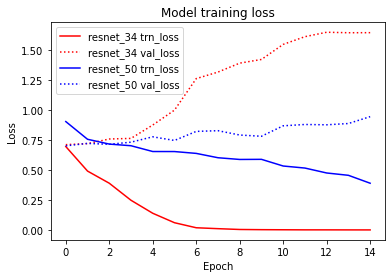

In [249]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_34.history['val_loss'], 'r:')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_resnet_50.history['val_loss'], 'b:')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34 trn_loss', 'resnet_34 val_loss',
            'resnet_50 trn_loss', 'resnet_50 val_loss',], loc='upper left')
plt.show()

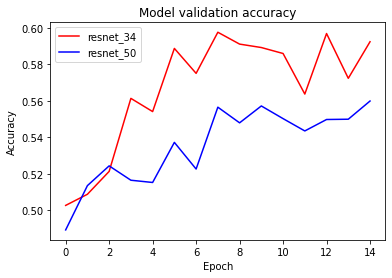

In [237]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

## 3. Ablation Study

In [242]:
plain_34 = build_resnet(input_shape=(32, 32, 3), is_50=False, is_resnet=False)
plain_34.summary()

Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_101 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_101 (ReLU)             (None, 16, 16, 64)        0         
_________________________________________________________________
stage1_0_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage0_0_conv0 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_102 (Bat (None, 8, 8, 64)          256

In [244]:
plain_50 = build_resnet(input_shape=(32, 32, 3), is_50=True, is_resnet=False)
plain_50.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_126 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
re_lu_126 (ReLU)             (None, 16, 16, 64)        0         
_________________________________________________________________
stage1_0_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage0_0_conv0 (Conv2D)      (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_127 (Bat (None, 8, 8, 64)          256

In [245]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples*0.8/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train'].num_examples*0.1/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd

13/72 [====>.........................] - ETA: 7s - loss: 0.7393 - accuracy: 0.4982

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


14/72 [====>.........................] - ETA: 7s - loss: 0.7385 - accuracy: 0.4994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


16/72 [=====>........................] - ETA: 7s - loss: 0.7339 - accuracy: 0.5071

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 6s - loss: 0.7324 - accuracy: 0.5092

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


45/72 [=================>............] - ETA: 3s - loss: 0.7213 - accuracy: 0.5146

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.7201 - accuracy: 0.5161

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 1s - loss: 0.7141 - accuracy: 0.5230

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.5281

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 58s 447ms/step - loss: 0.7090 - accuracy: 0.5281 - val_loss: 0.6931 - val_accuracy: 0.5202
Epoch 2/15
14/72 [====>.........................] - ETA: 5s - loss: 0.7059 - accuracy: 0.5198

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


15/72 [=====>........................] - ETA: 5s - loss: 0.7045 - accuracy: 0.5221

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


17/72 [======>.......................] - ETA: 5s - loss: 0.6982 - accuracy: 0.5363

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 5s - loss: 0.7004 - accuracy: 0.5324

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


46/72 [==================>...........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5439

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


50/72 [===================>..........] - ETA: 2s - loss: 0.6932 - accuracy: 0.5451

51/72 [====================>.........] - ETA: 2s - loss: 0.6936 - accuracy: 0.5442

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 1s - loss: 0.6961 - accuracy: 0.5404

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.5488

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 32s 447ms/step - loss: 0.6907 - accuracy: 0.5488 - val_loss: 0.6938 - val_accuracy: 0.4787
Epoch 3/15
14/72 [====>.........................] - ETA: 4s - loss: 0.6774 - accuracy: 0.5664 ETA: 4s - loss: 0.6727 - accura

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


16/72 [=====>........................] - ETA: 5s - loss: 0.6802 - accuracy: 0.5605

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


21/72 [=======>......................] - ETA: 5s - loss: 0.6857 - accuracy: 0.5484

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


47/72 [==================>...........] - ETA: 3s - loss: 0.6767 - accuracy: 0.5690

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


51/72 [====================>.........] - ETA: 2s - loss: 0.6764 - accuracy: 0.5681

52/72 [====================>.........] - ETA: 2s - loss: 0.6770 - accuracy: 0.5667

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


61/72 [========================>.....] - ETA: 1s - loss: 0.6753 - accuracy: 0.5725

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.5698

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 32s 453ms/step - loss: 0.6763 - accuracy: 0.5698 - val_loss: 0.7013 - val_accuracy: 0.4719
Epoch 4/15
13/72 [====>.........................] - ETA: 4s - loss: 0.6800 - accuracy: 0.5637

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


16/72 [=====>........................] - ETA: 3s - loss: 0.6778 - accuracy: 0.5691

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


18/72 [======>.......................] - ETA: 3s - loss: 0.6826 - accuracy: 0.5638

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


22/72 [========>.....................] - ETA: 4s - loss: 0.6803 - accuracy: 0.5679

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


48/72 [===================>..........] - ETA: 2s - loss: 0.6792 - accuracy: 0.5642

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


52/72 [====================>.........] - ETA: 2s - loss: 0.6771 - accuracy: 0.5687

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 1s - loss: 0.6775 - accuracy: 0.5694

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.5701

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0

72/72 [==============================] - 32s 452ms/step - loss: 0.6768 - accuracy: 0.5701 - val_loss: 0.7050 - val_accuracy: 0.4777
Epoch 5/15
 4/72 [>.............................] - ETA: 5s - loss: 0.6156 - accuracy: 0.6748

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


11/72 [===>..........................] - ETA: 4s - loss: 0.6559 - accuracy: 0.6001

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.6636 - accuracy: 0.5949

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


53/72 [=====================>........] - ETA: 1s - loss: 0.6654 - accuracy: 0.5918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


63/72 [=========================>....] - ETA: 0s - loss: 0.6678 - accuracy: 0.5875

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.5941

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 34s 471ms/step - loss: 0.6632 - accuracy: 0.5941 - val_loss: 0.7034 - val_accuracy: 0.4956
Epoch 6/15
37/72 [==============>...............] - ETA: 2s - loss: 0.6618 - accuracy: 0.5975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


46/72 [==================>...........] - ETA: 1s - loss: 0.6620 - accuracy: 0.5957

49/72 [===================>..........] - ETA: 1s - loss: 0.6605 - accuracy: 0.5970

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


64/72 [=========================>....] - ETA: 0s - loss: 0.6606 - accuracy: 0.5992

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.6002

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 36s 507ms/step - loss: 0.6598 - accuracy: 0.6002 - val_loss: 0.7048 - val_accuracy: 0.5114
Epoch 7/15
61/72 [========================>.....] - ETA: 0s - loss: 0.6470 - accuracy: 0.6208

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


65/72 [==========================>...] - ETA: 0s - loss: 0.6443 - accuracy: 0.6238

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


68/72 [===========================>..] - ETA: 0s - loss: 0.6397 - accuracy: 0.6298

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.6292

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0x

72/72 [==============================] - 32s 447ms/step - loss: 0.6405 - accuracy: 0.6292 - val_loss: 0.7199 - val_accuracy: 0.5237
Epoch 8/15
 2/72 [..............................] - ETA: 7s - loss: 0.5616 - accuracy: 0.7520

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 0s - loss: 0.6147 - accuracy: 0.6587

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


64/72 [=========================>....] - ETA: 0s - loss: 0.6141 - accuracy: 0.6595

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


68/72 [===========================>..] - ETA: 0s - loss: 0.6141 - accuracy: 0.6602

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.6117 - accuracy: 0.6631

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0x

72/72 [==============================] - 31s 440ms/step - loss: 0.6117 - accuracy: 0.6631 - val_loss: 0.7278 - val_accuracy: 0.5321
Epoch 9/15
 5/72 [=>............................] - ETA: 5s - loss: 0.5673 - accuracy: 0.7094

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/72 [========================>.....] - ETA: 0s - loss: 0.5959 - accuracy: 0.6792 ETA

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


65/72 [==========================>...] - ETA: 0s - loss: 0.5955 - accuracy: 0.6804

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


68/72 [===========================>..] - ETA: 0s - loss: 0.5941 - accuracy: 0.6815

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.5936 - accuracy: 0.6826

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0x

72/72 [==============================] - 31s 442ms/step - loss: 0.5936 - accuracy: 0.6826 - val_loss: 0.7676 - val_accuracy: 0.5290
Epoch 10/15
 6/72 [=>............................] - ETA: 4s - loss: 0.6329 - accuracy: 0.6426

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


64/72 [=========================>....] - ETA: 0s - loss: 0.5455 - accuracy: 0.7228

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


67/72 [==========================>...] - ETA: 0s - loss: 0.5487 - accuracy: 0.7203

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.7191

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0x

72/72 [==============================] - 32s 448ms/step - loss: 0.5505 - accuracy: 0.7191 - val_loss: 0.7746 - val_accuracy: 0.5415
Epoch 11/15
10/72 [===>..........................] - ETA: 4s - loss: 0.5602 - accuracy: 0.7074

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


67/72 [==========================>...] - ETA: 0s - loss: 0.5217 - accuracy: 0.7408

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


70/72 [============================>.] - ETA: 0s - loss: 0.5220 - accuracy: 0.7400

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.7408

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0x

72/72 [==============================] - 32s 447ms/step - loss: 0.5210 - accuracy: 0.7408 - val_loss: 0.8125 - val_accuracy: 0.5512
Epoch 12/15
 9/72 [==>...........................] - ETA: 4s - loss: 0.4681 - accuracy: 0.7821

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


70/72 [============================>.] - ETA: 0s - loss: 0.4657 - accuracy: 0.7820

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.4668 - accuracy: 0.7809

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0x

72/72 [==============================] - 31s 440ms/step - loss: 0.4668 - accuracy: 0.7809 - val_loss: 0.8743 - val_accuracy: 0.5398
Epoch 13/15
14/72 [====>.........................] - ETA: 3s - loss: 0.4419 - accuracy: 0.8052

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.4322 - accuracy: 0.8025 E

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0

72/72 [==============================] - 32s 449ms/step - loss: 0.4322 - accuracy: 0.8025 - val_loss: 0.8768 - val_accuracy: 0.5512
Epoch 14/15
17/72 [======>.......................] - ETA: 3s - loss: 0.3649 - accuracy: 0.8325

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.3449 - accuracy: 0.8480

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0

72/72 [==============================] - 32s 447ms/step - loss: 0.3449 - accuracy: 0.8480 - val_loss: 1.0194 - val_accuracy: 0.5496
Epoch 15/15
19/72 [======>.......................] - ETA: 3s - loss: 0.3219 - accuracy: 0.8682

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.3014 - accuracy: 0.8763

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0

72/72 [==============================] - 31s 441ms/step - loss: 0.3014 - accuracy: 0.8763 - val_loss: 1.0783 - val_accuracy: 0.5648


In [246]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples*0.8/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train'].num_examples*0.1/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_val,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd

13/72 [====>.........................] - ETA: 7s - loss: 0.7634 - accuracy: 0.5129

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


16/72 [=====>........................] - ETA: 7s - loss: 0.7622 - accuracy: 0.5093

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


19/72 [======>.......................] - ETA: 6s - loss: 0.7626 - accuracy: 0.5068

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


45/72 [=================>............] - ETA: 3s - loss: 0.7563 - accuracy: 0.5016

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 3s - loss: 0.7551 - accuracy: 0.5027

50/72 [===================>..........] - ETA: 2s - loss: 0.7550 - accuracy: 0.5034

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 1s - loss: 0.7536 - accuracy: 0.5012

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.4998

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 61s 456ms/step - loss: 0.7521 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5120
Epoch 2/15
13/72 [====>.........................] - ETA: 5s - loss: 0.7399 - accuracy: 0.4961

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


16/72 [=====>........................] - ETA: 5s - loss: 0.7391 - accuracy: 0.4998

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 5s - loss: 0.7403 - accuracy: 0.4930

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


46/72 [==================>...........] - ETA: 3s - loss: 0.7329 - accuracy: 0.5003

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.7312 - accuracy: 0.5029

51/72 [====================>.........] - ETA: 2s - loss: 0.7312 - accuracy: 0.5034

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 1s - loss: 0.7280 - accuracy: 0.5072

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7292 - accuracy: 0.5054

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 32s 451ms/step - loss: 0.7292 - accuracy: 0.5054 - val_loss: 0.6913 - val_accuracy: 0.5343
Epoch 3/15
14/72 [====>.........................] - ETA: 5s - loss: 0.7253 - accuracy: 0.5100

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


15/72 [=====>........................] - ETA: 5s - loss: 0.7239 - accuracy: 0.5122

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


20/72 [=======>......................] - ETA: 5s - loss: 0.7262 - accuracy: 0.5081

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


47/72 [==================>...........] - ETA: 3s - loss: 0.7231 - accuracy: 0.5060

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


51/72 [====================>.........] - ETA: 2s - loss: 0.7242 - accuracy: 0.5052

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 1s - loss: 0.7235 - accuracy: 0.5046

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7242 - accuracy: 0.5030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0x

72/72 [==============================] - 32s 449ms/step - loss: 0.7242 - accuracy: 0.5030 - val_loss: 0.6937 - val_accuracy: 0.5029
Epoch 4/15
10/72 [===>..........................] - ETA: 5s - loss: 0.7176 - accuracy: 0.5051

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


13/72 [====>.........................] - ETA: 5s - loss: 0.7161 - accuracy: 0.5018

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


15/72 [=====>........................] - ETA: 4s - loss: 0.7190 - accuracy: 0.5036

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


21/72 [=======>......................] - ETA: 4s - loss: 0.7218 - accuracy: 0.5004

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


48/72 [===================>..........] - ETA: 2s - loss: 0.7203 - accuracy: 0.5037

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


52/72 [====================>.........] - ETA: 2s - loss: 0.7204 - accuracy: 0.5049

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 1s - loss: 0.7212 - accuracy: 0.5042

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7213 - accuracy: 0.5042

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0

72/72 [==============================] - 33s 456ms/step - loss: 0.7213 - accuracy: 0.5042 - val_loss: 0.7019 - val_accuracy: 0.4757
Epoch 5/15
 4/72 [>.............................] - ETA: 6s - loss: 0.7133 - accuracy: 0.5205

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 8/72 [==>...........................] - ETA: 6s - loss: 0.7160 - accuracy: 0.4980

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.7175 - accuracy: 0.4981

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


52/72 [====================>.........] - ETA: 1s - loss: 0.7170 - accuracy: 0.4985

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


64/72 [=========================>....] - ETA: 0s - loss: 0.7168 - accuracy: 0.4972

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7165 - accuracy: 0.4984

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 34s 480ms/step - loss: 0.7165 - accuracy: 0.4984 - val_loss: 0.7028 - val_accuracy: 0.4809
Epoch 6/15
30/72 [===========>..................] - ETA: 3s - loss: 0.7196 - accuracy: 0.4911

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


38/72 [==============>...............] - ETA: 2s - loss: 0.7187 - accuracy: 0.4918

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


56/72 [======================>.......] - ETA: 1s - loss: 0.7188 - accuracy: 0.4938

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7183 - accuracy: 0.4937

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 444ms/step - loss: 0.7183 - accuracy: 0.4937 - val_loss: 0.6919 - val_accuracy: 0.5512
Epoch 7/15
30/72 [===========>..................] - ETA: 3s - loss: 0.7088 - accuracy: 0.5065

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


37/72 [==============>...............] - ETA: 3s - loss: 0.7090 - accuracy: 0.5071

39/72 [===============>..............] - ETA: 2s - loss: 0.7092 - accuracy: 0.5065

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


54/72 [=====================>........] - ETA: 1s - loss: 0.7117 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.5034

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 32s 444ms/step - loss: 0.7105 - accuracy: 0.5034 - val_loss: 0.7101 - val_accuracy: 0.5074
Epoch 8/15
35/72 [=============>................] - ETA: 3s - loss: 0.7123 - accuracy: 0.4984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


42/72 [================>.............] - ETA: 2s - loss: 0.7124 - accuracy: 0.4981

45/72 [=================>............] - ETA: 2s - loss: 0.7121 - accuracy: 0.4974

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


64/72 [=========================>....] - ETA: 0s - loss: 0.7126 - accuracy: 0.4995

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7113 - accuracy: 0.5011

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 

72/72 [==============================] - 36s 503ms/step - loss: 0.7113 - accuracy: 0.5011 - val_loss: 0.7486 - val_accuracy: 0.4974
Epoch 9/15
 3/72 [>.............................] - ETA: 7s - loss: 0.7172 - accuracy: 0.5286

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


46/72 [==================>...........] - ETA: 2s - loss: 0.7103 - accuracy: 0.5021

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


49/72 [===================>..........] - ETA: 2s - loss: 0.7107 - accuracy: 0.5019

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


51/72 [====================>.........] - ETA: 1s - loss: 0.7106 - accuracy: 0.5021

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


56/72 [======================>.......] - ETA: 1s - loss: 0.7100 - accuracy: 0.5043

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7094 - accuracy: 0.5061

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd

72/72 [==============================] - 32s 453ms/step - loss: 0.7094 - accuracy: 0.5061 - val_loss: 0.7057 - val_accuracy: 0.5250
Epoch 10/15
 5/72 [=>............................] - ETA: 6s - loss: 0.7103 - accuracy: 0.5195

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


53/72 [=====================>........] - ETA: 1s - loss: 0.7086 - accuracy: 0.5080

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


57/72 [======================>.......] - ETA: 1s - loss: 0.7087 - accuracy: 0.5079

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


64/72 [=========================>....] - ETA: 0s - loss: 0.7084 - accuracy: 0.5085

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.5083

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd

72/72 [==============================] - 32s 447ms/step - loss: 0.7082 - accuracy: 0.5083 - val_loss: 0.7166 - val_accuracy: 0.5135
Epoch 11/15
 6/72 [=>............................] - ETA: 5s - loss: 0.7177 - accuracy: 0.4890

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


50/72 [===================>..........] - ETA: 1s - loss: 0.7075 - accuracy: 0.5005

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


53/72 [=====================>........] - ETA: 1s - loss: 0.7070 - accuracy: 0.5011

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 0s - loss: 0.7075 - accuracy: 0.5027

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7078 - accuracy: 0.5026

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd

72/72 [==============================] - 32s 445ms/step - loss: 0.7078 - accuracy: 0.5026 - val_loss: 0.7215 - val_accuracy: 0.5272
Epoch 12/15
10/72 [===>..........................] - ETA: 5s - loss: 0.7056 - accuracy: 0.5055

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


55/72 [=====================>........] - ETA: 1s - loss: 0.7067 - accuracy: 0.5024

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


60/72 [========================>.....] - ETA: 0s - loss: 0.7061 - accuracy: 0.5041

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


65/72 [==========================>...] - ETA: 0s - loss: 0.7055 - accuracy: 0.5051

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.5055

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd

72/72 [==============================] - 32s 446ms/step - loss: 0.7056 - accuracy: 0.5055 - val_loss: 0.7134 - val_accuracy: 0.5069
Epoch 13/15
11/72 [===>..........................] - ETA: 5s - loss: 0.7151 - accuracy: 0.4950

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


56/72 [======================>.......] - ETA: 1s - loss: 0.7109 - accuracy: 0.4934

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


62/72 [========================>.....] - ETA: 0s - loss: 0.7107 - accuracy: 0.4962

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


68/72 [===========================>..] - ETA: 0s - loss: 0.7105 - accuracy: 0.4965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.4971

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd

72/72 [==============================] - 32s 456ms/step - loss: 0.7100 - accuracy: 0.4971 - val_loss: 0.7300 - val_accuracy: 0.5273
Epoch 14/15
 9/72 [==>...........................] - ETA: 5s - loss: 0.7086 - accuracy: 0.4957

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


56/72 [======================>.......] - ETA: 1s - loss: 0.7051 - accuracy: 0.5050

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


58/72 [=======================>......] - ETA: 1s - loss: 0.7051 - accuracy: 0.5042

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


61/72 [========================>.....] - ETA: 0s - loss: 0.7052 - accuracy: 0.5032

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


67/72 [==========================>...] - ETA: 0s - loss: 0.7060 - accuracy: 0.5028

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.5031

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd

72/72 [==============================] - 32s 443ms/step - loss: 0.7057 - accuracy: 0.5031 - val_loss: 0.7242 - val_accuracy: 0.4907
Epoch 15/15
15/72 [=====>........................] - ETA: 4s - loss: 0.7020 - accuracy: 0.5018

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


61/72 [========================>.....] - ETA: 0s - loss: 0.7053 - accuracy: 0.5053

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


64/72 [=========================>....] - ETA: 0s - loss: 0.7056 - accuracy: 0.5049

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


68/72 [===========================>..] - ETA: 0s - loss: 0.7052 - accuracy: 0.5053

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


72/72 [==============================] - ETA: 0s - loss: 0.7056 - accuracy: 0.5056

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0x

72/72 [==============================] - 32s 446ms/step - loss: 0.7056 - accuracy: 0.5056 - val_loss: 0.7443 - val_accuracy: 0.5074


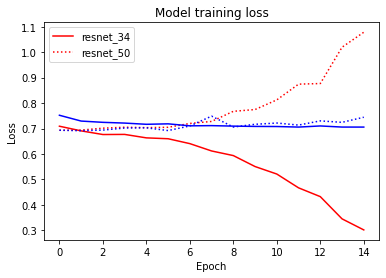

In [247]:
import matplotlib.pyplot as plt

plt.plot(history_plain_34.history['loss'], 'r')
plt.plot(history_plain_34.history['val_loss'], 'r:')
plt.plot(history_plain_50.history['loss'], 'b')
plt.plot(history_plain_50.history['val_loss'], 'b:')

plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_34 trn_loss', 'plain_34 val_loss',
            'plain_50 trn_loss', 'plain_50 val_loss',], loc='upper left')

plt.show()

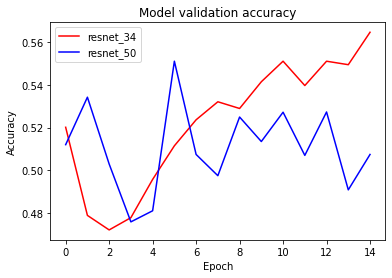

In [248]:
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'plain_50'], loc='upper left')
plt.show()

## 회고

### 배운 점
- Residual network (shortcut connection)을 구현할 때에, 서로 다른 경로를 지나온 두 텐서의 dimension 에 유의해야 한다.
- 가중치를 통과한 텐서에 batch normalization을 해준 후에 activation 을 수행한다.
- residual block 에서 두 텐서를 더하기 전에 batch normalization 을 수행하고, adding 후에 activation을 수행한다.

### 아쉬운 점
- 구현에서 오류로 인해 막힌 부분이 있었어서 학습을 끝까지 (15 epochs) 까지 돌리지 못했다.

### 어려웠던 점
- shortcut 과 conv Layer 를 통과한 tensor를 더하는 부분에서 dimension이 맞지 않는 두 텐서를 더하는 부분에서 오류로 인해 오랜 시간을 보냈다. 

### 느낀점
- 논문에 나오지 않은 부분을 가정하여 보려
- ResNet 을 처음부터 도움 없이 구현해볼 수 있는 기회여서 좋았다.
- 제발 시간관리 좀 잘 하자 (오류 해결을 하기 쉽게 처음부터 구현 계획을 마무리 짓고, 다음으로 넘어가자)
- debugging 을 하기 쉽게 모듈화 하자